# Homework 04 - Applied ML

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn import preprocessing
%matplotlib inline

## 1. Predict the skin color of a soccer player

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

### 1.1 Exploratory Data Analysis, Feature Selection and Feature engineering

In [108]:
# Import data 
data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep = ',')

In [109]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [110]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

##### First clean of data
According to the given information in the [data description](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md), we get rid off all the dyads that correspond to players whose picture is not available.

In [111]:
data_clean = data[(data.photoID.notnull())]

##### Have a glance at the labels

Thus, we check whether happens that one of the two raters do not assign the label. We see that both of them do their job. 

In [112]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


In [113]:
player_data = data_clean.groupby('playerShort')

Verify that all the players only belong to one club

In [114]:
player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()

array([1])

In [115]:
player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()

array([1])

In [116]:
players = player_data.agg({
        'club' : 'first',
        'leagueCountry' : 'first',
        'birthday' : 'first',
        'height' : 'first',
        'weight' : 'mean',
        'position' : 'first',
        'games' : 'sum',
        'victories' : 'sum',
        'ties' : 'sum',
        'defeats' : 'sum',
        'goals' : 'sum',
        'yellowCards': 'sum',
        'yellowReds': 'sum',
        'redCards' : 'sum',
        'rater1' : 'mean',
        'rater2' : 'mean',
        'refNum' : 'count',
        'refCountry' : 'count',
        'meanIAT' : 'mean',
        'meanExp' : 'mean'
        
    })

In [117]:
players

,refCountry,games,rater1,club,position,goals,refNum,yellowCards,ties,meanExp,leagueCountry,rater2,weight,birthday,meanIAT,height,defeats,redCards,yellowReds,victories
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,166,654,0.25,Fulham FC,Center Back,9,166,19,179,0.494575,England,0.00,71.0,08.11.1979,0.346459,182.0,228,0,0,247
aaron-hunt,99,336,0.00,Werder Bremen,Attacking Midfielder,62,99,42,73,0.449220,Germany,0.25,73.0,04.09.1986,0.348818,183.0,122,1,0,141
aaron-lennon,101,412,0.25,Tottenham Hotspur,Right Midfielder,31,101,11,97,0.491482,England,0.25,63.0,16.04.1987,0.345893,165.0,115,0,0,200
aaron-ramsey,104,260,0.00,Arsenal FC,Center Midfielder,39,104,31,42,0.514693,England,0.00,76.0,26.12.1990,0.346821,178.0,68,1,0,150
abdelhamid-el-kaoutari,37,124,0.25,Montpellier HSC,Center Back,1,37,8,40,0.335587,France,0.25,73.0,17.03.1990,0.331600,180.0,43,2,4,41
abdou-traore_2,42,97,0.75,Girondins Bordeaux,Right Midfielder,3,42,11,23,0.296562,France,0.75,74.0,17.01.1988,0.320079,180.0,33,0,1,41
abdoulaye-diallo_2,20,24,0.75,Stade Rennes,Goalkeeper,0,20,0,8,0.400818,France,1.00,80.0,30.03.1992,0.341625,189.0,8,0,0,8
abdoulaye-keita_2,2,3,0.75,Girondins Bordeaux,Goalkeeper,0,2,0,1,0.417225,France,1.00,83.0,19.08.1990,0.355406,188.0,2,0,0,0
abdoulwhaid-sissoko,56,121,1.00,Stade Brest,Defensive Midfielder,3,56,21,25,0.429630,France,1.00,68.0,20.03.1990,0.348178,180.0,62,2,0,34


In [118]:
label_1 = players['rater1']

In [119]:
label_2 = players['rater2']

In [120]:
players.drop('rater1', axis = 1, inplace = True)

In [121]:
players.drop('rater2', axis= 1, inplace = True)

In [125]:
players

,refCountry,games,club,position,goals,refNum,yellowCards,ties,meanExp,leagueCountry,weight,birthday,meanIAT,height,defeats,redCards,yellowReds,victories
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,166,654,Fulham FC,Center Back,9,166,19,179,0.494575,0,71.0,08.11.1979,0.346459,182.0,228,0,0,247
aaron-hunt,99,336,Werder Bremen,Attacking Midfielder,62,99,42,73,0.449220,2,73.0,04.09.1986,0.348818,183.0,122,1,0,141
aaron-lennon,101,412,Tottenham Hotspur,Right Midfielder,31,101,11,97,0.491482,0,63.0,16.04.1987,0.345893,165.0,115,0,0,200
aaron-ramsey,104,260,Arsenal FC,Center Midfielder,39,104,31,42,0.514693,0,76.0,26.12.1990,0.346821,178.0,68,1,0,150
abdelhamid-el-kaoutari,37,124,Montpellier HSC,Center Back,1,37,8,40,0.335587,1,73.0,17.03.1990,0.331600,180.0,43,2,4,41
abdou-traore_2,42,97,Girondins Bordeaux,Right Midfielder,3,42,11,23,0.296562,1,74.0,17.01.1988,0.320079,180.0,33,0,1,41
abdoulaye-diallo_2,20,24,Stade Rennes,Goalkeeper,0,20,0,8,0.400818,1,80.0,30.03.1992,0.341625,189.0,8,0,0,8
abdoulaye-keita_2,2,3,Girondins Bordeaux,Goalkeeper,0,2,0,1,0.417225,1,83.0,19.08.1990,0.355406,188.0,2,0,0,0
abdoulwhaid-sissoko,56,121,Stade Brest,Defensive Midfielder,3,56,21,25,0.429630,1,68.0,20.03.1990,0.348178,180.0,62,2,0,34


### Baseline model

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
from sklearn.utils import shuffle

In [70]:
from sklearn.multioutput import MultiOutputClassifier

#### Preprocess variable to be used as input for the classifier

In [ ]:
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [122]:
def convert_string_variable(df, attribute):
    
    df[attribute] = df[attribute].fillna('Unknown')
    
    le = preprocessing.LabelEncoder()
    
    le.fit(df[attribute])
    
    df[attribute] = le.transform(df[attribute]) 

In [123]:
convert_string_variable(players, 'leagueCountry')

##### Categorise features

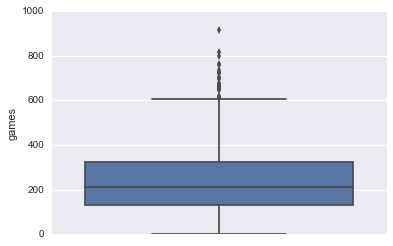

In [133]:
sns.boxplot(players['games'], orient='v')

#### Split train and test

In [78]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(players, label_1, test_size=0.33, random_state=42)

In [105]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [106]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [107]:
multi_target_forest.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').